In [2]:
import logging, gensim, bz2
from gensim import corpora, models, similarities
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from bs4 import BeautifulSoup
import nltk
import re
from nltk.corpus import stopwords
import string
import itertools
exclude = set(string.punctuation)
import matplotlib
%matplotlib inline 

### open test texts

In [3]:
soup = BeautifulSoup(open( unicode(u"all_source_texts/Re-Nutriv Script_Final Translation Template_deadline 20. april-en-da-T.mxliff")), 'lxml')
soup2 = BeautifulSoup(open(u"all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_Übersetzten-en-tr-T.mxliff"), 'lxml')

In [4]:
print "The text language source is", soup.file["source-language"]
print "The text language target is", soup.file["target-language"]

The text language source is en
The text language target is da


### what a file looks like

In [5]:
print soup.prettify()

<html>
 <body>
  <xliff m:level="1" m:version="2.0" version="1.2" xmlns="urn:oasis:names:tc:xliff:document:1.2" xmlns:m="http://www.memsource.com/mxlf/2.0">
   <file datatype="x-undefined" m:file-format="XLS" m:task-id="QD2UhI1HxBsq4axG0" original="Re-Nutriv Script_Final Translation Template_deadline 20. april.xlsx" source-language="en" target-language="da">
    <group id="0">
     <context-group>
      <context context-type="x-file-part">
       xl/sharedStrings.xml
      </context>
     </context-group>
     <trans-unit id="QD2UhI1HxBsq4axG0:0" m:confirmed="0" m:created-at="0" m:created-by="" m:gross-score="0.0" m:level-edited="false" m:locked="false" m:modified-at="0" m:modified-by="" m:para-id="2-tu1" m:score="0.0" m:trans-origin="null" xml:space="preserve">
      <source>
       Estée Lauder ID Script for Re-Nutriv Module {b&gt;| Final | 1/9/14&lt;b}
      </source>
      <target>
      </target>
      <alt-trans origin="machine-trans">
       <target>
       </target>
      </alt

### targeting the content

In [13]:
strings=[]
for string in soup.find_all("source"):
    strings.append(string.string)
    
strings2=[]
for string2 in soup2.find_all("source"):
    strings2.append(string2.string)

In [14]:

def tokenize(s):
# tokenize a string
    tokens=[]
    wnl = nltk.WordNetLemmatizer()
    tokens.append(nltk.word_tokenize(''.join(w for w in s)))
    tokens = [w for w in tokens[0] if not re.search('\.*[0-9]+\.*', w)]
    tokens = [w for w in tokens if w not in exclude]
    tokens = [w for w in tokens if len(w) > 2]
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    tokens = [wnl.lemmatize(t) for t in tokens]
    return tokens

def load_and_tokenize(path):
    try:
        soup = BeautifulSoup(open( path), 'lxml')
        strings=[]
        for string in soup.find_all("source"):
            strings.append(string.string)
        return tokenize( strings )
    except:
        print
        print "## CANNOT LOAD:" + path + " ##"
        return None

    


In [15]:
tokens = tokenize( strings )

tokens2 = tokenize( strings2 )

texts = [tokens] + [tokens2]

In [9]:
# path = "all_source_texts/Underbilag 3 3 Leverandørens generelle løsningsbeskrivelse - BI-en-da-T.mxliff"
# soup = BeautifulSoup(open( path.encode(sys.getfilesystemencoding())), 'lxml')

In [10]:
# import os
# import sys
# root = u"all_source_texts/"
# for filename in os.listdir(root):
#     filename = root + filename
#     print filename
#     open( filename.encode(sys.getfilesystemencoding()), "r")

---------

### load lda environement (locally)

In [11]:
lda = gensim.models.ldamodel.LdaModel.load('lda/wikipedia_lda', mmap='r')

In [12]:
for a in lda.print_topics(10):
    print a
    print "="*50

0.029*species + 0.013*mm + 0.010*genus + 0.009*grey + 0.009*brown + 0.008*dark + 0.008*described + 0.007*costa + 0.007*gelechiidae + 0.007*pale
0.046*cricket + 0.020*matches + 0.017*match + 0.016*cricketer + 0.016*wickets + 0.014*class + 0.013*batsman + 0.013*runs + 0.011*innings + 0.009*scored
0.014*oregon + 0.014*pref + 0.009*sashes + 0.008*saas + 0.008*vmi + 0.007*tiwari + 0.007*narendra + 0.007*saskatoon + 0.007*mendoza + 0.006*portland
0.024*sternites + 0.020*breuning + 0.015*gay + 0.013*lgbt + 0.009*lesbian + 0.007*transgender + 0.006*sex + 0.006*yes + 0.005*soman + 0.005*pride
0.052*sabha + 0.046*janata + 0.032*lok + 0.018*lucknow + 0.015*patel + 0.014*malawi + 0.014*dt + 0.013*bhat + 0.011*hebei + 0.011*allahabad
0.023*race + 0.021*racing + 0.013*tour + 0.012*stage + 0.011*car + 0.010*cycling + 0.010*ret + 0.008*cyclist + 0.008*championship + 0.007*road
0.008*published + 0.008*book + 0.006*books + 0.005*magazine + 0.005*editor + 0.004*novel + 0.004*author + 0.004*writer + 0.004

### indexing the tokens of the corpus

In [15]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

### running lda on corpus

In [16]:
corpus_lda = lda[corpus]

### displaying the major topics

In [17]:
a=[]
for doc in corpus_lda:
    a.append(sorted(doc, key=lambda item: (-1)*item[1]))

In [18]:
i = 0
topics_direct= []
for corpus in a:
    print "text %s" %i
    for s in corpus[:3]:
        print str(s) 
        print "\t" + unicode(lda.print_topic(int(s[0])))
        topics_direct.append( lda() )
    i += 1
    print

text 0
(30, 0.070452445237317335)
	0.023*armenian + 0.020*win + 0.018*azerbaijan + 0.016*vidhan + 0.015*fight + 0.015*boxing + 0.013*baku + 0.013*heavyweight + 0.013*armenia + 0.012*submission
(33, 0.058792669446901771)
	0.003*cast + 0.003*david + 0.003*james + 0.003*george + 0.003*robert + 0.003*michael + 0.003*directed + 0.002*william + 0.002*paul + 0.002*richard
(78, 0.049444834958563659)
	0.009*fuscous + 0.005*ochreous + 0.005*hindwings + 0.003*plot + 0.003*story + 0.002*novel + 0.002*man + 0.002*suffused + 0.002*love + 0.002*you

text 1
(78, 0.071577646734696784)
	0.009*fuscous + 0.005*ochreous + 0.005*hindwings + 0.003*plot + 0.003*story + 0.002*novel + 0.002*man + 0.002*suffused + 0.002*love + 0.002*you
(77, 0.065610040624224999)
	0.004*television + 0.004*films + 0.004*festival + 0.004*tv + 0.004*actor + 0.004*awards + 0.004*directed + 0.004*show + 0.004*award + 0.003*episode
(94, 0.059406689544151646)
	0.015*orchestra + 0.012*opera + 0.010*piano + 0.009*symphony + 0.008*compose

In [19]:
print lda.print_topic(77)
print lda.print_topic(60)
print 
print lda.print_topic(57)
print lda.print_topic(78)

0.004*television + 0.004*films + 0.004*festival + 0.004*tv + 0.004*actor + 0.004*awards + 0.004*directed + 0.004*show + 0.004*award + 0.003*episode
0.014*gk + 0.012*vfl + 0.008*tba + 0.007*hee + 0.007*melbourne + 0.006*eun + 0.006*prem + 0.006*geelong + 0.005*victorian + 0.005*kyung

0.026*station + 0.024*railway + 0.009*airport + 0.008*train + 0.008*route + 0.007*road + 0.006*rail + 0.006*highway + 0.006*bus + 0.006*junction
0.009*fuscous + 0.005*ochreous + 0.005*hindwings + 0.003*plot + 0.003*story + 0.002*novel + 0.002*man + 0.002*suffused + 0.002*love + 0.002*you


In [20]:
d={}
for w in tokens:
    d[w]=tokens.count(w)
    
d2={}
for w in tokens2:
    d2[w]=tokens2.count(w)

In [21]:
remove=[]
for u,v in d.iteritems():
    if v==1:
        remove.append(u)
        
remove2=[]
for u,v in d2.iteritems():
    if v==1:
        remove2.append(u)

In [22]:
liste = [w for w in tokens if w not in remove]
liste2 = [w for w in tokens2 if w not in remove2]

### collocations

In [23]:
mots = ' '.join(liste)
mots2 = ' '.join(liste2)

In [24]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
tokens = nltk.wordpunct_tokenize(mots)
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(4)
finder.nbest(bigram_measures.pmi, 20)

[(u'much', u'know'),
 (u'read', u'question'),
 (u'secret', u'family'),
 (u'module', u'final'),
 (u'final', u'learning'),
 (u'next', u'on'),
 (u'share', u'benefit'),
 (u'topic', u'next'),
 (u'beautiful', u'skin'),
 (u'best', u'choice'),
 (u'coveted', u'treasure'),
 (u'extraordinary', u'result'),
 (u'skin', u'solution'),
 (u'that', u'it'),
 (u'black', u'diamond'),
 (u'diamond', u'truffle'),
 (u'always', u'explain'),
 (u'completion', u'screenlearning'),
 (u'learning', u'point'),
 (u'screenlearning', u'point')]

In [25]:
bigram_measures2 = nltk.collocations.BigramAssocMeasures()
tokens2 = nltk.wordpunct_tokenize(mots2)
finder2 = BigramCollocationFinder.from_words(tokens2)
finder2.apply_freq_filter(4)
finder2.nbest(bigram_measures2.pmi, 20)

[(u'right', u'holder')]

In [26]:
len(mots)

5901

In [27]:
len(mots2)

598

- rules (constraint words)
- contract/law (specific)
- report
collocations
confusion matrix
tf-idf

# construct a projection matrix from a frequency space to a topic space

## construct topics

In [28]:
# translate the lda topics in dictionnaries
i = 0
topics = dict()
wordset = set()
for a in lda.print_topics(100):
    topic = dict()
#     print a
    pairs = a.split( ' + ')
    for p in pairs:
        pair = p.split('*')
#         print pair[0]
        value = float(pair[0])
        key = unicode(pair[1])
        topic[key] = value
        wordset.add(key)
    topics[i] = topic   
    i += 1
    


In [29]:
i = 0
word_dict = dict()
for w in wordset:
    word_dict[i] = w
    i += 1
    
    
word2int = dict()
for i in word_dict:
    word2int[word_dict[i]] = i

In [30]:
print len(wordset)

952


In [31]:
import math
#normalize topics
for t in topics:
    s = 0.0
    for v in topics[t].values():
        s+= v**2
    s = math.sqrt(s)
    inv_s = 1.0 / float(s)
    
    for key in topics[t]:
        topics[t][key] = topics[t][key] * inv_s

## topic vizualisation: word cloud

In [36]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def WordCloudTopic( i ):
    # Generate a word cloud image
    wc = WordCloud(background_color="white", max_words=2000,
               max_font_size=40, random_state=42)
    wordcloud = wc.generate_from_frequencies(topics[i].items())    
    plt.imshow(wordcloud)
    plt.axis("off")

In [37]:
WordCloudTopic( 25 )

## construct matrix

In [38]:
from scipy.sparse import *
from scipy import *
M = dok_matrix((len(wordset),len(topics)), dtype=float32)

print M.todense()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [39]:
for i in range(0,len(wordset)):
    word = word_dict[i]
    for j in range(0, len(topics)):
        topic = topics[j]
        if word in topic.keys():
            M[ i,j] = topic[word]
        

## convert tokens to frequency space

In [40]:



def tokensToFrequencies( tokens ):
    x = dok_matrix((1, len(wordset)), dtype=float32)
    for t in tokens:
        if t in word2int.keys():
            x[0,word2int[t]] += 1          
    return x

In [41]:
# test
tokens = load_and_tokenize(unicode(u"source_texts/_WL-Contact_Technical_And_Functional_Proposal-1-en-de-T.mxliff"))
x = tokensToFrequencies(tokens)
print x
print word_dict[696]

  (0, 385)	2.0
  (0, 470)	2.0
  (0, 672)	2.0
  (0, 244)	2.0
  (0, 463)	14.0
  (0, 148)	1.0
  (0, 686)	3.0
  (0, 947)	14.0
  (0, 696)	4.0
  (0, 628)	7.0
  (0, 692)	1.0
  (0, 491)	1.0
  (0, 96)	3.0
  (0, 399)	1.0
  (0, 799)	5.0
  (0, 68)	2.0
  (0, 361)	1.0
  (0, 803)	1.0
  (0, 920)	1.0
  (0, 247)	3.0
user


# convert frequency vector to the topic space

In [42]:
def getSemanticVector( path ):
    tokens = load_and_tokenize(path)
    if tokens == None:
        print " in getSemanticVector: no tokens"
        return None
    else:
        return tokensToFrequencies( tokens ) * M


def getClosestTopic(v , topic_to_display = -1):
    if v != None:
        i_max = 0
        m = 0
        results = dict()
        for i in range(0,len(topics)):
            results[i] = v[0,i]  
        k = 1
        if topic_to_display > 0:
            printResults_closestTopics( results, topic_to_display)

        return results
    else:
        return None

def printResults_closestTopics( results, n):
    if results != None:
        k = 1
        for i in sorted(results.items(), key=lambda x: x[1])[::-1][:n]:
            print str(k) + ": "  + str(topics[i[0]].keys())
            k += 1
            print

In [43]:
results = getClosestTopic( getSemanticVector( unicode(u"source_texts/_WL-Contact_Technical_And_Functional_Proposal-1-en-de-T.mxliff") ) )

In [44]:
print printResults_closestTopics(results, 3)

print results

1: [u'development', u'management', u'business', u'students', u'research', u'founded', u'institute', u'services', u'education', u'technology']

2: [u'thessaloniki', u'gr', u'hellenic', u'xxx', u'athens', u'greek', u'greece', u'crete', u'tracklist', u'larissa']

3: [u'web', u'users', u'mobile', u'app', u'system', u'taluka', u'user', u'android', u'data', u'software']

None
{0: 0.0, 1: 0.0, 2: 0.51639777, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 1.0264004, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 9.0510359, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 1.6941135, 36: 1.1176589, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.458094, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 3.3454967, 64: 0.0, 65: 0.0, 

# topic distribution

In [45]:
import os
import sys
filelist = []
root = u"all_source_texts/"
for filename in os.listdir(root):
    filename = root + filename
    print filename
    filelist .append(filename.encode(sys.getfilesystemencoding()))
    
#     import glob
# filelist = glob.glob('all_source_texts/*.mxliff')
    
for f in filelist:
    print f

all_source_texts/13_pd_spec_fortigel_b-en-ru-T.mxliff
all_source_texts/140702_swatch_SOM_A4_preview-en-fr-T.mxliff
all_source_texts/1410-0002 DEEP SEA MONSTER Press Outs-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 FAST FLESH EATERS pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 fearsome fighters Press Outs-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 Giants of the Jurassic pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 Killers of Cretaceous pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 mega meateater pressouts -en-fr_ca-CR.mxliff
all_source_texts/1814_Imbox Imagebrochure_REN 2_2015-8-20-en-de-T.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN COVER-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 1-8-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 25-40-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 41-48-en-fr_ca-CR.mxliff


In [ ]:
score_per_topic = dict()
for i in topics:
    score_per_topic[i] = 0.0
    
print "%s files" %len(filelist)
i = 0
all_results = dict()
for f in filelist:
    print i,
    results = getClosestTopic( getSemanticVector( f ))
    all_results[f] = results
    if results != None:
        for key in results:
            score_per_topic[key] += results[key]
    i += 1

159 files
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
## CANNOT LOAD:all_source_texts/2.1 fcc_1200m_kazakhstan-tengizchevroil_dl_intl_2-2_G_EN-en-de-T.mxliff ##
 in getSemanticVector: no tokens
32
## CANNOT LOAD:all_source_texts/2.2.1 fcc_1200m_kazakhstan-tengizchevroil_dl_intl_2-2_G_EN-en-de-T.mxliff ##
 in getSemanticVector: no tokens
33 34


In [ ]:
print "raw distribution"
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

plt.plot(score_per_topic.keys(), score_per_topic.values(),'orange', alpha = 0.6)

# find labels

In [ ]:
import operator
topics_labels = dict()

print "unrecognized labels:"
for i in topics: 
    x = topics[i]
    sorted_x = sorted(x.items(), key=operator.itemgetter(1))[::-1]
    s = ''
    for e in sorted_x:
        try:
            s+= ' ' + str( e[0].decode('utf-8') )
        except:
            print e[0]
#     print s
    
    topics_labels[i] = s

In [ ]:
score_per_topic_sorted =  sorted(score_per_topic.items(), key=operator.itemgetter(1))[::-1]

X = []
Y = []
k = 0

print "most common topics (score & labels)"
for e in score_per_topic_sorted:
    i = e[0]
    Y.append(e[1])
    X.append(topics_labels[i])
    if k < 10:
        print str(e[1]) + "\t"+ str(topics_labels[i])
    k+=1

In [ ]:
# run the cell below before this one
import plotly.tools as tls
tls.embed(url)

In [ ]:
print "most common topics (score & labels)"
for e in score_per_topic_sorted:
    i = e[0]
    Y.append(e[1])
    X.append(topics_labels[i])
    print str(i) + ": " + str(e[1]) + "\t"+ str(topics_labels[i])

# explore topics as a graph


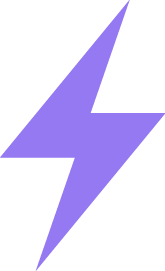

ValueError: Timeout value connect was (10.0, 10.0), but it must be an int or float.

In [36]:
from lightning import Lightning
from numpy import random, asarray
import networkx as nx
lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')
lgn.set_size(size='large')

TRESHOLD = 2


class idGenerator:
    def __init__(self):
        self.id = 0
    def get(self):
        self.id += 1
        return self.id - 1
    
    
class node:
    def __init__(self, index, label, weight = 30.):
        self.index = index
        self.label = label
        self.childs = []
        self.weight = weight
    def addChild( self, c ):
        self.childs.append( c )
        
    def getGraph(self):
        graph = nx.Graph()
        graph.add_node( self.index, weight = self.weight, label = self.label, color = (231, 76, 60))
        for c in self.childs:
            graph.add_node( c.index, weight = c.weight, label = c.label, color = (41, 128, 185))
            graph.add_edge(self.index, c.index )
            for cc in c.childs:
                graph.add_node( cc.index, weight = cc.weight, label = cc.label, color = (236, 240, 241))
                graph.add_edge(c.index, cc.index )
        
        return graph
        mat = asarray(nx.adjacency_matrix(graph).todense())
        lgn.force(mat, size = weights)
        nx.draw(graph)
        
    
def makeGraphFromText( f ):
    id = idGenerator()
    topic_scores = getClosestTopic( getSemanticVector( f ))
    text_node = node( id.get() , f)
    k = 0
    for t in topic_scores:
        if topic_scores[t] > TRESHOLD:
            topic_node = node( id.get(), t, weight = 0.5 * topic_scores[t] )
            topic = topics[t]
            for detail in topic:
                detail_node = node( id.get(), detail, weight =  20 * topic[detail])
                topic_node.addChild(detail_node)
            text_node.addChild( topic_node )
            
    return text_node
            

In [ ]:
G = makeGraphFromText( f )

print f
graph = G.getGraph()
mat = asarray(nx.adjacency_matrix(graph).todense())
weights =  nx.get_node_attributes(graph, 'weight').values()
labels = nx.get_node_attributes(graph, 'label').values()
colors = nx.get_node_attributes(graph, 'color').values()
lgn.force(mat, size = weights, labels = labels, color= colors)

# similarity

In [ ]:
semantic_vectors = dict()
for f in filelist:
    print f
    v = getSemanticVector( f )
    if len(v.data):
        semantic_vectors[f] = v
print " ------------------------------- "
# test
for s in semantic_vectors.values():
    print list(s[0,:])

In [ ]:
def norm(v):
    s = 0
    for d in v.data:
        s+= d**2
    return sqrt(s)

def similarity( a, b):
    # cosine similarity
    p = (a.dot(b.transpose()) / (norm(a) * norm(b))).data
    if len(p):
        return p[0]


def closestFile( path ):
    u = getSemanticVector(path)
    similarities = dict()
    for s in semantic_vectors:
        similarities[s] = similarity(semantic_vectors[s],u)
        
    k = 1
    for i in sorted(similarities.items(), key=lambda x: x[1])[::-1][:10]:
        print str(k) + "  |  "  + str(i)
        k += 1

In [ ]:
path = u"all_source_texts/"+"ENG - Basic Modules_Eating Habits_V59-MH-en-ko-T.mxliff"
closestFile(path)